# Problem set 2

## Team
Please write here your names and team number.

* Team name: Group F
* Team members:
    1. Aditi Joshi (243311)
    2. Dominik Allen (232487)
    3. Lonny Chen (216697)

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [1]:
import torch

# Check is GPU is enabled (Apple’s "MPS" backend)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
#if str(device) == "cuda:0":
#  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: mps


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

In [2]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

In [3]:
# Load data
data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory

In [4]:
# Inspect dataset
print(f"The dataset has {len(data)} images")
print(f'Dataset type {type(data)}')
print(f'Dataset element type {type(data[0])}')
print(f'Target type {type(data[0][1])}') #second element of tuple
print(f'Image type {type(data[0][0])}') #first element of tuple

The dataset has 27000 images
Dataset type <class 'torchvision.datasets.eurosat.EuroSAT'>
Dataset element type <class 'tuple'>
Target type <class 'int'>
Image type <class 'PIL.Image.Image'>


Image format: None
Image mode: RGB
Image size: (64, 64)
Image numpy shape: (64, 64, 3)
Picture number 19899 with label: 7


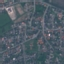

In [5]:
# Inspect one PIL image
print(f'Image format: {data[0][0].format}')
print(f'Image mode: {data[0][0].mode}')
print(f'Image size: {data[0][0].size}')
print(f'Image numpy shape: {np.array(data[0][0]).shape}')

# Original inspection
randint = np.random.randint(len(data))
pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees. 
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized. 
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

In [6]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np

#ADDED: libraries
import seaborn as sns
sns.set_style("darkgrid")
from PIL import Image
import textwrap
from torchvision import transforms

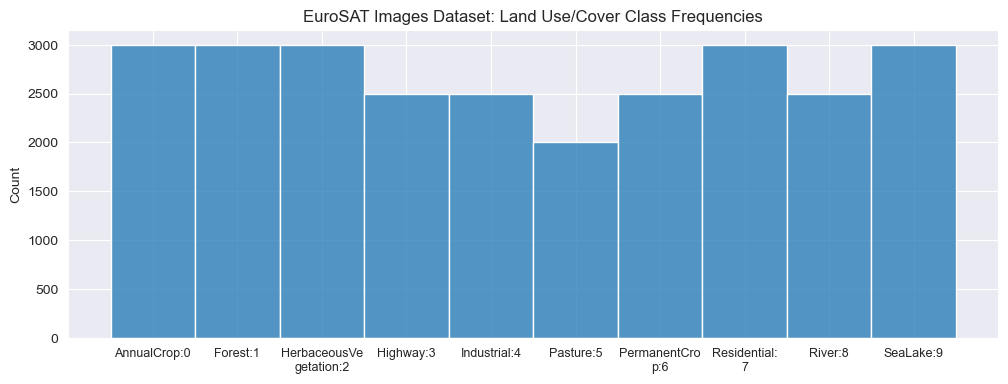

In [7]:
def rotate_picture(picture, rotation):
    '''#DONE: implemented most frequent n people'''
    #return AssertionError if other rotation input
    assert rotation in [90, 180, 270, 360], 'Rotation angle is not a multiple of 90°'
    
    #Use PIL.Image.Image.rotate
    return picture.rotate(rotation) #counter-clockwise


def plot_histogram(data):
    fig, ax = plt.subplots(figsize=(12, 4)) #originally (10, 6)
    
    '''#DONE: here your code'''
    xlabels = [f'{k}:{v}' for k, v in data.class_to_idx.items()]
    xlabels_wrapped = [textwrap.fill(xl, width=12) for xl in xlabels]
    sns.histplot(data=data.targets, bins=len(data.classes), discrete=True)
    plt.xticks(list(data.class_to_idx.values()), xlabels_wrapped, fontsize=9)
    
    return fig, ax

new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)             

fig, ax = plot_histogram(data)
plt.title('EuroSAT Images Dataset: Land Use/Cover Class Frequencies');
#fig.show()

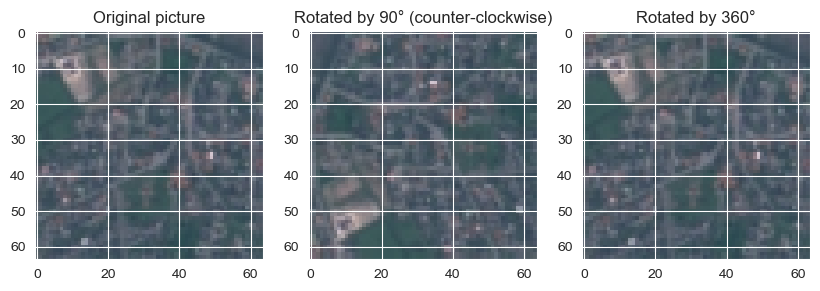

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90° (counter-clockwise)")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°");

In [9]:
class RotateEuroSAT(Dataset):
    def __init__(self, 
                 original_data:Dataset, 
                 length:int, 
                 shares:list,
                 device=None,
                 seed=42):
        
        self.original_data = original_data
        self.length = length
        assert sum(shares) == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label
    
    def _create_rotated_dataset(self):
        """#DONE: implement solution"""

        class MyRotatedDataset(Dataset):
            def __init__(self, original_data, length, shares, seed, device):
                #Set random seeds
                np.random.seed(seed)
                #torch.manual_seed(seed)

                #Per-class loop to get random indices by class shares
                indices = []
                for target, share in enumerate(shares):
                    target_indices = (torch.tensor(original_data.targets) == target).nonzero(as_tuple=True)[0] #GPT Q&A
                    indices += np.random.choice(target_indices, size=int(length*share), replace=False).tolist() #w/o replacement
                    
                #Create new dataset pre-rotation
                self.randomized_dataset = Subset(original_data, indices)
                self.to_tensor = transforms.ToTensor()
                self.device = device

            def __len__(self):
                return len(self.length)

            def __getitem__(self, idx):
                #Perform randomized rotation upon data loading
                rotation = np.random.choice([90, 180, 270, 360])
                image = rotate_picture(self.randomized_dataset[idx][0], rotation)
                label = self.randomized_dataset[idx][1]

                # +1. Needed for data use in neural networks
                image_tensor = self.to_tensor(image) 
                label_tensor = torch.tensor(label)

                # +2. Optionally move to GPU (upon loading)
                if self.device:
                    image_tensor = image_tensor.to(self.device)
                    label_tensor = label_tensor.to(self.device)
                
                return image_tensor, label_tensor

        # Instantiate and return rotated dataset
        dataset = MyRotatedDataset(self.original_data, self.length, self.shares, self.seed, self.device)
        
        return dataset
    

In [10]:
rotated_data = RotateEuroSAT(data, 
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             seed=42,
                             device=device) #ADDED to put data on GPU

rotated_data

In [11]:
# CHECK target distribution
targets = [rotated_data[idx][1].to('cpu') for idx in range(len(rotated_data))]
np.unique(np.array(targets), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [12]:
# CHECK data types and devices
print(type(rotated_data[0][0])) #PIL is a Tensor now!
print(rotated_data[0][0].device) #on MPS!
print(rotated_data[0][0].shape)

<class 'torch.Tensor'>
mps:0
torch.Size([3, 64, 64])


In [13]:
train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F #ADDED for nn.functional.pad

class MyMaxPoolSlow(nn.Sequential):
    def __init__(self,
                 kernel_size, 
                 stride=1,
                 padding=0):
    
        super().__init__()
        '''#DONE: construction your model'''
    
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
    
    def forward(self, x):
        '''#DONE: forward step'''

        #Heavily "inspired" by Lab 4 "Constructing a convolutional layer"
        #Setup initial dimension variables
        if x.dim() < 4:
            x = x.unsqueeze(0) # shape becomes (1, C, H, W)
        batch_size, in_channels, H, W = x.shape
        if self.padding > 0:
            x = F.pad(x, (self.padding,) * 4) # padding (W, W, H, H)

        out_list = []
        for b in range(batch_size):
            x_b = x[b] #one sample in batch

            out_b_list = []
            for ch in range(in_channels):
                x_bc = x_b[ch] #one channel in sample
                
                #Calculate, setup output dimensions
                H, W = x_bc.shape
                out_H = (H - self.kernel_size)//self.stride + 1
                out_W = (W - self.kernel_size)//self.stride + 1
                out_bc = torch.zeros((out_H, out_W))

                #Per-channel: max pooling loop through H, W of x
                for i in range(out_H):
                    for j in range(out_W):
                        h_start = i * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = j * self.stride
                        w_end = w_start + self.kernel_size
                        region = x_bc[h_start:h_end, w_start:w_end]
                        
                        #Actual max pooling operation!
                        out_bc[i, j] = torch.max(region)
                out_b_list.append(out_bc)
            
            out_b = torch.stack(out_b_list)
            out_list.append(out_b)

        out = torch.stack(out_list)
        return out.to(device)
        

In [95]:
class MyMaxPoolFast(nn.Sequential):
    def __init__(self,
                 kernel_size, 
                 stride=1,
                 padding=0):

        super().__init__()
        '''#DONE: construction your model'''
    
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        '''#DONE: forward step'''
        if x.dim() < 4:
            x = x.unsqueeze(0) # shape becomes (1, C, H, W)
        batch_size, in_channels, H, W = x.shape
        if self.padding > 0:
            x = F.pad(x, (self.padding,) * 4) # padding (W, W, H, H)

        #Below is ALL CHAT GPT (PyTorch vectorized operations)
        N, C, H, W = x.shape
        k, s = self.kernel_size, self.stride

        # Compute output dimensions
        out_H = (H - k) // s + 1
        out_W = (W - k) // s + 1

        # Create sliding windows using unfold (vectorized)
        x_unf = x.unfold(2, k, s).unfold(3, k, s)  # shape: N x C x out_H x out_W x k x k
        out, _ = x_unf.contiguous().view(N, C, out_H, out_W, -1).max(dim=-1)
        
        return out.to(device)

In [96]:
#Testing MyMaxPool
X, y = train_data[8]
X.unsqueeze(0).shape
my_maxpool = MyMaxPoolFast(2, 2, 0)
a = my_maxpool(X).squeeze(0)
maxpool2d = nn.MaxPool2d(2, 2)
b = maxpool2d(X)
(a == b).all()

tensor(True, device='mps:0')

In [103]:
class MyCNNModel(nn.Sequential):
    
    def __init__(self,
                 conv_spec: list[list[tuple]],
                 fc_spec: list[tuple],
                 n_classes):

        '''#DONE: construction your model'''
        # Use generic layer structure idea from Lab 4
        # 1. Build `layers` list of NN modules from `conv_spec` list of Conv2d spec tuples
        layers = []

        # 1a. Add "stacked" convolutional layers:
        for conv_i in conv_spec:
            for j, (ich, och, k, s, p) in enumerate(conv_i):
                layers.extend([
                    nn.Conv2d(in_channels=ich, out_channels=och, kernel_size=k, stride=s, padding=p),
                    nn.ReLU()
                ])
            #layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            #layers.append(MyMaxPoolSlow(kernel_size=2, stride=2))
            layers.append(MyMaxPoolFast(kernel_size=2, stride=2))

        # 1b. Add fully-connected layers
        layers.append(nn.Flatten())
        for i, (ifeat, ofeat) in enumerate(fc_spec):
            layers.append(nn.Linear(in_features=ifeat, out_features=ofeat))
            if i < (len(fc_spec)-1):
                layers.append(nn.ReLU())
        # Return "logits" here -> Y_pred -> nn.CrossEntropyLoss (softmax + NLLLoss)

        # 2. Call parent class constructor method with built-up `layers` list
        super().__init__(*layers)

    #def forward(self, x):
        '''#TODO: forward step'''

In [104]:
'''#DONE: print one iteration of your model to test its correctness'''

#ADDED
n_classes = len(data.classes)

#Arch0 ~= LeNet-5
#in_channels, out_channels, kernel_size, stride (1), padding (0)
conv_spec0 = [[(3, 6, 5, 1, 2)],   #Conv Layer 1 -> 64x64x16 -> 32x32x6
              [(6, 16, 5, 1, 0)],  #Conv Layer 2 -> 28x28x16 -> 14x14x16
              [(16, 40, 5, 1, 0)]] #Conv Layer 3 -> 10x10x40 -> 5x5x40
#in_features, out_features
fc_spec0 = [(5*5*40, 256), (256, 84), (84, n_classes)] #FC1 -> FC2 -> Output

#Arch1 <- DomNet
conv_spec1 = [[(3, 16, 3, 1, 1)],  #Conv Layer 1 -> 64x64x16 -> 32x32x16
              [(16, 32, 5, 1, 2)], #Conv Layer 2 -> 32x32x32 -> 16x16x32
              [(32, 64, 3, 1, 1)]] #Conv Layer 3 -> 16x16x64 -> 8x8x64
fc_spec1 = [(8*8*64, 128), (128, n_classes)] #FC1 -> Output

#Arch2 <- DALNet-7
conv_spec2 = [[(3, 64, 5, 1, 2)], #Conv Layer 1 -> 64x64x64 -> 32x32x64
              [(64, 128, 3, 1, 1), (128, 128, 3, 1, 1)],  #Conv Layer 2 -> 32x32x128 -> 16x16x128
              [(128, 256, 3, 1, 1), (256, 256, 3, 1, 1)]] #Conv Layer 3 -> 16x16x256 -> 8x8x256
fc_spec2 = [(8*8*256, 1024), (1024, n_classes)] #FC1 -> Output

#my_model = MyCNNModel(n_classes).to(device)
my_model = MyCNNModel(conv_spec2, fc_spec2, n_classes).to(device)

X, y = train_data[0]
my_model(X[None, :])

tensor([[-0.0260,  0.0272,  0.0030,  0.0164,  0.0091,  0.0192,  0.0068, -0.0126,
          0.0204, -0.0234]], device='mps:0', grad_fn=<LinearBackward0>)

In [ ]:
from torchinfo import summary
summary(my_model, input_size=(1, 3, 64, 64)) #batch, C, H, W

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [112]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 10, #v0: 1
    'learning_rate': 0.001, #v0: 0.001
    'optimizer':'Adam',
    'seed':42,
}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc #no `.item()` causes need to move to CPU when using for plot?
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss))) #causes avg_test_loss[1] > 1!
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc



Epoch:9 - Avg loss:0.99634 - Avg acc:0.62591: 100%|██████████| 125/125 [00:42<00:00,  2.97it/s]

Final running batch averages are 1.00 loss and 62.6% acurracy


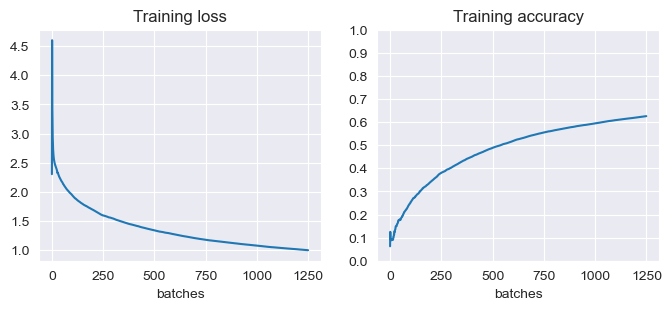

In [113]:
'''#DONE: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
#ADDED: Re-run this to "re-start" training
my_model = MyCNNModel(conv_spec2, fc_spec2, n_classes).to(device)

my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3)) #ADDED figsize
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax1.set_yticks(np.arange(0, 1.1, 0.1)) #ADDED
ax0.set_title('Training loss')
ax0.set_xlabel('batches');
ax1.set_title('Training accuracy');
ax1.set_xlabel('batches');

#ADDED for printing
print(f'Final running batch averages are {train_loss[-1]:.2f} loss and {train_acc[-1]:.1%} acurracy') 

Final running batch averages are 0.69 loss and 79.0% acurracy


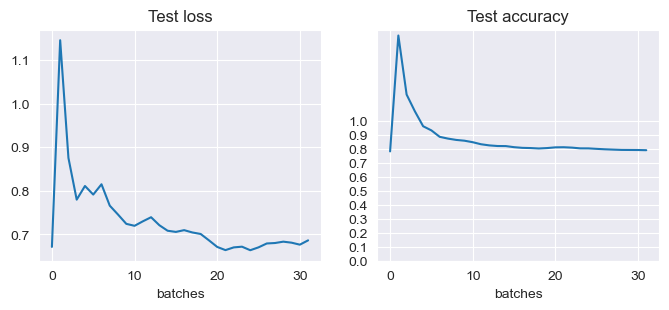

In [114]:
'''#DONE: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_data)
test_acc = [t.cpu() for t in test_acc] #FIX: Move test_acc tensor from MPS to CPU

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3)) #ADDED figsize
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax1.set_yticks(np.arange(0, 1.1, 0.1)) #ADDED
ax0.set_title('Test loss')
ax0.set_xlabel('batches');
ax1.set_title('Test accuracy')
ax1.set_xlabel('batches');

#ADDED for printing
print(f'Final running batch averages are {test_loss[-1]:.2f} loss and {test_acc[-1]:.1%} acurracy')

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [123]:
import copy

def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    '''#TODO: here your code '''

    #Loop through all combinations of two hyperparameters
    i = 0
    best_avg_acc = -0.1 #initializes even if initial train_acc is 0!
    for bs in batch_sizes:
        for lr in learning_rates:
            #Setup this iteration's config
            i += 1
            cfg_i = cfg
            cfg_i['batch_size'] = bs
            cfg_i['learning_rate'] = lr

            #Instantiate model and trainer, run training
            print(f'Training model with batch size {bs} and learning rate {lr}')
            model_i = MyCNNModel(conv_spec2, fc_spec2, n_classes).to(device) #arguments defined outside of function
            trainer_i = Trainer(model_i, cfg_i)
            train_loss_i, train_acc_i = trainer_i.train(train_data)

            #Keep best model/config/loss/acc
            if i==0 or train_acc_i[-1] > best_avg_acc:
                best_model = copy.deepcopy(model_i)
                best_cfg = cfg_i.copy() #need this copy()!
                best_avg_loss = train_loss_i[-1]
                best_avg_acc = train_acc_i[-1]
   
    return best_model, best_cfg, best_avg_loss, best_avg_acc

best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f'Best model has batch size {best_cfg['batch_size']} and learning rate {best_cfg['learning_rate']}') #ADDED
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")

Training model with batch size 32 and learning rate 0.1


Epoch:0 - Avg loss:67556211.02906 - Avg acc:0.09990: 100%|██████████| 250/250 [00:33<00:00,  7.54it/s] 
Epoch:1 - Avg loss:33710415.07917 - Avg acc:0.09976: 100%|██████████| 250/250 [00:30<00:00,  8.09it/s]
Epoch:2 - Avg loss:22458608.41517 - Avg acc:0.09892: 100%|██████████| 250/250 [00:33<00:00,  7.55it/s]
Epoch:3 - Avg loss:16838336.61777 - Avg acc:0.09938: 100%|██████████| 250/250 [00:31<00:00,  7.94it/s]
Epoch:4 - Avg loss:13467973.46653 - Avg acc:0.09945: 100%|██████████| 250/250 [00:30<00:00,  8.22it/s]
Epoch:5 - Avg loss:11221814.16849 - Avg acc:0.09857: 100%|██████████| 250/250 [00:33<00:00,  7.54it/s]
Epoch:6 - Avg loss:9617781.59913 - Avg acc:0.09838: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s] 
Epoch:7 - Avg loss:8414957.77655 - Avg acc:0.09856: 100%|██████████| 250/250 [00:30<00:00,  8.20it/s]
Epoch:8 - Avg loss:7479546.98732 - Avg acc:0.09832: 100%|██████████| 250/250 [00:30<00:00,  8.19it/s]
Epoch:9 - Avg loss:6731293.21834 - Avg acc:0.09843: 100%|██████████| 250/2

Training model with batch size 32 and learning rate 0.01


Epoch:9 - Avg loss:5.23111 - Avg acc:0.09698: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s]


Training model with batch size 32 and learning rate 0.001


Epoch:9 - Avg loss:0.81349 - Avg acc:0.69537: 100%|██████████| 250/250 [00:35<00:00,  7.02it/s]


Training model with batch size 64 and learning rate 0.1


Epoch:0 - Avg loss:55202483.84476 - Avg acc:0.09728: 100%|██████████| 125/125 [01:08<00:00,  1.84it/s]
Epoch:1 - Avg loss:27490394.72499 - Avg acc:0.09739: 100%|██████████| 125/125 [01:27<00:00,  1.43it/s]
Epoch:2 - Avg loss:18302429.34616 - Avg acc:0.09709: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
Epoch:3 - Avg loss:13717653.03468 - Avg acc:0.09798: 100%|██████████| 125/125 [00:43<00:00,  2.90it/s]
Epoch:4 - Avg loss:10969726.20727 - Avg acc:0.09816: 100%|██████████| 125/125 [00:46<00:00,  2.71it/s]
Epoch:5 - Avg loss:9138997.92059 - Avg acc:0.09865: 100%|██████████| 125/125 [00:43<00:00,  2.87it/s]
Epoch:6 - Avg loss:7831933.33079 - Avg acc:0.09820: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]
Epoch:7 - Avg loss:6851961.98203 - Avg acc:0.09871: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]
Epoch:8 - Avg loss:6089955.79087 - Avg acc:0.09856: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
Epoch:9 - Avg loss:5480472.85632 - Avg acc:0.09892: 100%|██████████| 125/125 

Training model with batch size 64 and learning rate 0.01


Epoch:9 - Avg loss:4.61736 - Avg acc:0.36552: 100%|██████████| 125/125 [03:04<00:00,  1.48s/it]


Training model with batch size 64 and learning rate 0.001


Epoch:9 - Avg loss:0.86424 - Avg acc:0.68270: 100%|██████████| 125/125 [00:39<00:00,  3.18it/s]


Training model with batch size 128 and learning rate 0.1


Epoch:0 - Avg loss:59866921.33307 - Avg acc:0.10509: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s] 
Epoch:1 - Avg loss:29693994.14645 - Avg acc:0.10456: 100%|██████████| 63/63 [00:32<00:00,  1.93it/s]
Epoch:2 - Avg loss:19743347.94680 - Avg acc:0.10298: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
Epoch:3 - Avg loss:14787846.85046 - Avg acc:0.10203: 100%|██████████| 63/63 [00:32<00:00,  1.96it/s]
Epoch:4 - Avg loss:11820858.93385 - Avg acc:0.10241: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
Epoch:5 - Avg loss:9845490.32131 - Avg acc:0.10173: 100%|██████████| 63/63 [00:39<00:00,  1.60it/s] 
Epoch:6 - Avg loss:8435795.44733 - Avg acc:0.10080: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
Epoch:7 - Avg loss:7379224.93534 - Avg acc:0.10054: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]
Epoch:8 - Avg loss:6557862.69965 - Avg acc:0.10036: 100%|██████████| 63/63 [01:45<00:00,  1.68s/it]
Epoch:9 - Avg loss:5901034.07577 - Avg acc:0.09977: 100%|██████████| 63/63 [01:14<00:00,  1.1

Training model with batch size 128 and learning rate 0.01


Epoch:9 - Avg loss:6.41465 - Avg acc:0.33252: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


Training model with batch size 128 and learning rate 0.001


Epoch:9 - Avg loss:1.00611 - Avg acc:0.61801: 100%|██████████| 63/63 [01:38<00:00,  1.56s/it]

Best model has batch size 32 and learning rate 0.001
Best model achieves 0.81 loss and 69.5% accuracy


Final running batch averages are 0.63 loss and 80.6% acurracy


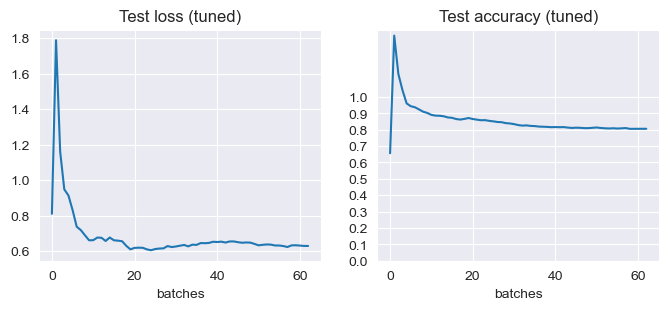

In [141]:
'''#DONE: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
#ADDED: instantiate new trainer with best model, use for checking test loss/accuracy only
my_best_trainer = Trainer(best_model, best_cfg)

best_test_loss, best_test_acc = my_best_trainer.test(test_data)                                    
best_test_acc = [t.cpu() for t in best_test_acc] #FIX: Move test_acc tensor from MPS to CPU
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3)) #ADDED figsize
ax0.plot(range(len(best_test_loss)), best_test_loss)
ax1.plot(range(len(best_test_acc)), best_test_acc)
ax1.set_yticks(np.arange(0, 1.1, 0.1)) #ADDED
ax0.set_title('Test loss (tuned)')
ax0.set_xlabel('batches');
ax1.set_title('Test accuracy (tuned)')
ax1.set_xlabel('batches');

#ADDED for printing
print(f'Final running batch averages are {best_test_loss[-1]:.2f} loss and {best_test_acc[-1]:.1%} acurracy')

## Task 4: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [ ]:
'''#TODO: import and fine-tune a pretrained model'''
loaded_model = None #here your loaded model
loaded_trainer = Trainer(loaded_model, cfg)

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


<a name="results-and-discussion"></a>
# Task  5: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             





In [91]:
#Build DataFrame for reporting
import pandas as pd
df = pd.DataFrame(np.nan,
                  index = ['Accuracy (train)', 'Loss (train)', 'Accuracy (test)', 'Loss (test)'],
                  columns = ['your model', 'pre-trained model', 'your tuned model'])
df.index.name = 'Test metric'

In [115]:
#Input base model metrics
df['your model'] = [train_acc[-1], train_loss[-1], test_acc[-1].item(), test_loss[-1]]
#df['your tuned model'] = [best_avg_acc, best_avg_loss, best_test_acc[-1].item(), best_test_loss[-1]]
df

,your model,pre-trained model,your tuned model
Test metric,,,
Accuracy (train),0.625913,NaN,NaN
Loss (train),0.996336,NaN,NaN
Accuracy (test),0.789819,NaN,NaN
Loss (test),0.686398,NaN,NaN
